# Baseline CNN Feature Visualisation

Load the saved checkpoint (`Baseline CNN2.pt`) and explore learned filters and intermediate activations.


## 1. Setup
Import the required libraries, configure paths, and detect the runtime device. Update `CHECKPOINT_PATH` or `TRAIN_DIR` if your files live elsewhere.


In [21]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torchvision import transforms
from torchvision.datasets import ImageFolder

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {DEVICE}')

# Make project root directory the working directory
def find_project_root(current_path, marker='requirements.txt'):
    for parent in current_path.parents:
        if (parent / marker).exists():
            return parent
    return current_path  # Fallback to current if marker not found

PROJECT_ROOT = find_project_root(Path.cwd())
print(f'Project root directory set to: {PROJECT_ROOT}')

CHECKPOINT_PATH = PROJECT_ROOT / 'training notebooks/cnn/Baseline_CNN2.pt'
TRAIN_DIR = PROJECT_ROOT / 'Dataset/fruit_ripeness_dataset/archive (1)/dataset/train'
IMAGE_SIZE = 224


Using device: cpu
Project root directory set to: /Users/Oscar/Desktop/Honours/AI/Ass2


## 2. Recreate the Model Architecture
The checkpoint stores weights only, so we need the `SimpleCNN` definition to load them. Adjust the architecture if your training notebook differs.


In [22]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes: int, image_size: int = 224):
        super().__init__()
        self.image_size = image_size
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.25),
        )
        feature_size = 128 * (image_size // 8) * (image_size // 8)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(feature_size, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


## 3. Load the Checkpoint
Load the trained weights and restore the class labels stored in the checkpoint dictionary.


In [23]:
if not CHECKPOINT_PATH.exists():
    raise FileNotFoundError(f'Checkpoint not found at {CHECKPOINT_PATH.resolve()}')

checkpoint = torch.load(CHECKPOINT_PATH, map_location='cpu')
class_names = checkpoint.get('class_names')
if class_names is None:
    raise KeyError('class_names missing from checkpoint; regenerate the file with metadata.')

image_size = checkpoint.get('image_size', IMAGE_SIZE)
model = SimpleCNN(num_classes=len(class_names), image_size=image_size)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(DEVICE).eval()
print(f'Loaded checkpoint with classes: {class_names}')


Loaded checkpoint with classes: ['freshapples', 'freshbanana', 'freshoranges', 'rottenapples', 'rottenbanana', 'rottenoranges', 'unripe apple', 'unripe banana', 'unripe orange']


## 4. Prepare a Sample Image
Pick an example from the training set (or provide a custom image) and apply the same preprocessing used during training.


Samples available: 16217
Selected example label: unripe banana
Predicted class: unripe banana (index: 7) with confidence 0.5754


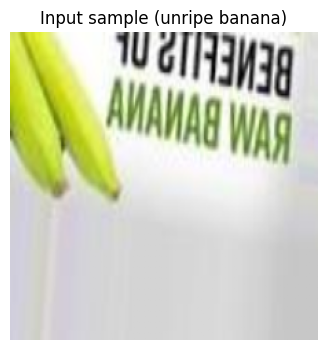

In [24]:
from torchvision.transforms.functional import to_tensor

if not TRAIN_DIR.exists():
    raise FileNotFoundError(f'Train directory not found at {TRAIN_DIR.resolve()}')

preprocess = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
raw_dataset = ImageFolder(TRAIN_DIR)
print(f'Samples available: {len(raw_dataset)}')

# Choose sample image by index
#sample_image, sample_label = raw_dataset[5000]  # Changed index to change the sample image

# Random sample image choice
sample_image, sample_label = raw_dataset[np.random.randint(len(raw_dataset))]

sample_tensor = preprocess(sample_image).unsqueeze(0).to(DEVICE)
print(f'Selected example label: {class_names[sample_label]}')

with torch.no_grad():
    outputs = model(sample_tensor)
    probabilities = torch.softmax(outputs, dim=1).cpu().squeeze(0)
    predicted_index = torch.argmax(probabilities).item()
    predicted_class = class_names[predicted_index]
    confidence = probabilities[predicted_index].item()
print(f'Predicted class: {predicted_class} (index: {predicted_index}) with confidence {confidence:.4f}')


def show_image(img_tensor):
    img = img_tensor.clone().cpu()
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    img = img.clamp(0, 1)
    plt.imshow(img.permute(1, 2, 0))
    plt.axis('off')

plt.figure(figsize=(4, 4))
show_image(sample_tensor.squeeze(0))
plt.title(f'Input sample ({class_names[sample_label]})')
plt.show()


## 5. Visualise First-Layer Filters
Plot the learned weights of the first convolutional layer as RGB patches.


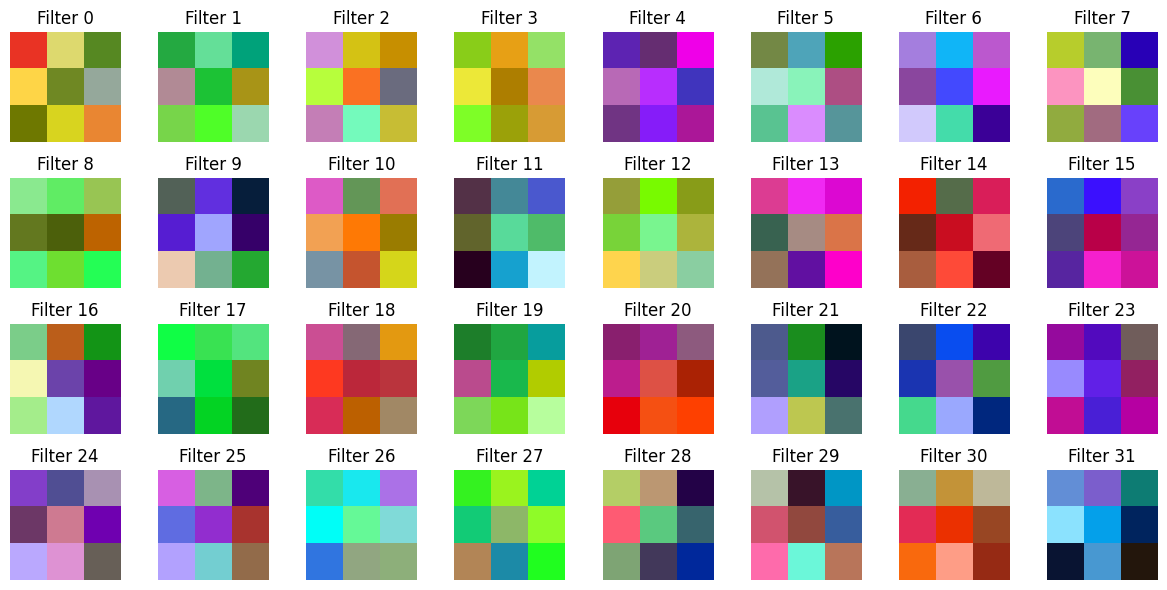

In [25]:
def plot_conv_filters(conv_weight, max_filters=32):
    weights = conv_weight.detach().cpu()
    num_filters = min(weights.size(0), max_filters)
    cols = 8
    rows = int(np.ceil(num_filters / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 1.5, rows * 1.5))
    axes = axes.flatten()
    for idx, ax in enumerate(axes):
        if idx < num_filters:
            filt = weights[idx]
            filt = (filt - filt.min()) / (filt.max() - filt.min() + 1e-5)
            ax.imshow(filt.permute(1, 2, 0))
            ax.set_title(f'Filter {idx}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plot_conv_filters(model.features[0].weight, max_filters=32)


## 6. Capture Feature Maps via Hooks
Register forward hooks on convolution and pooling layers to inspect their activations.


In [26]:
from collections import OrderedDict

feature_maps = OrderedDict()
layer_map = OrderedDict([
    ('conv1', model.features[0]),
    ('pool1', model.features[3]),
    ('conv2', model.features[4]),
    ('pool2', model.features[7]),
    ('conv3', model.features[8]),
    ('pool3', model.features[11]),
])

hooks = []
for name, layer in layer_map.items():
    def save_activation(module, inp, out, layer_name=name):
        feature_maps[layer_name] = out.detach().cpu()
    hooks.append(layer.register_forward_hook(save_activation))

with torch.no_grad():
    _ = model(sample_tensor)

for hook in hooks:
    hook.remove()

print('Captured feature maps:', list(feature_maps.keys()))


Captured feature maps: ['conv1', 'pool1', 'conv2', 'pool2', 'conv3', 'pool3']


## 7. Visualise Feature Maps
Plot a subset of channels from each captured activation to see how representations evolve through the network.


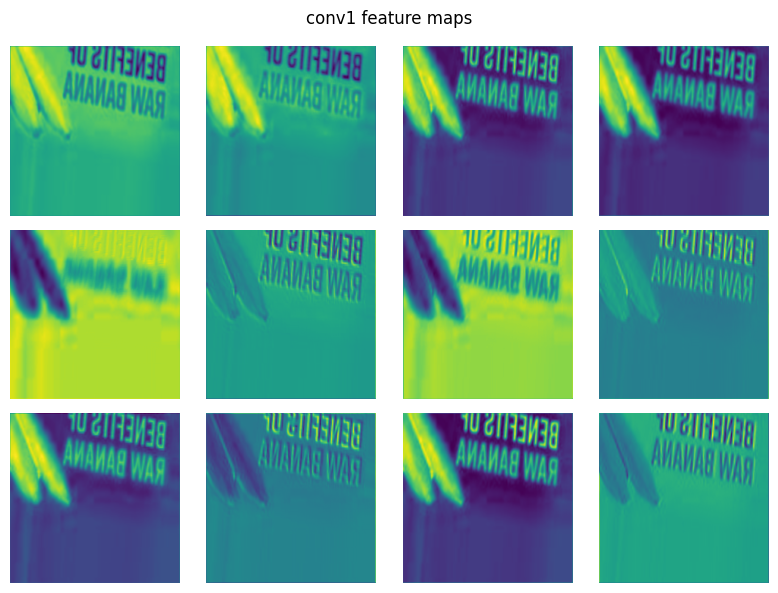

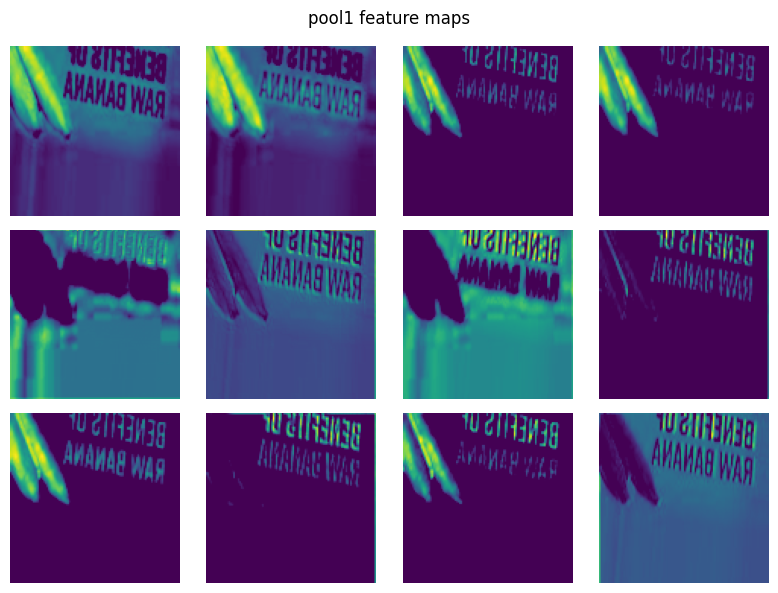

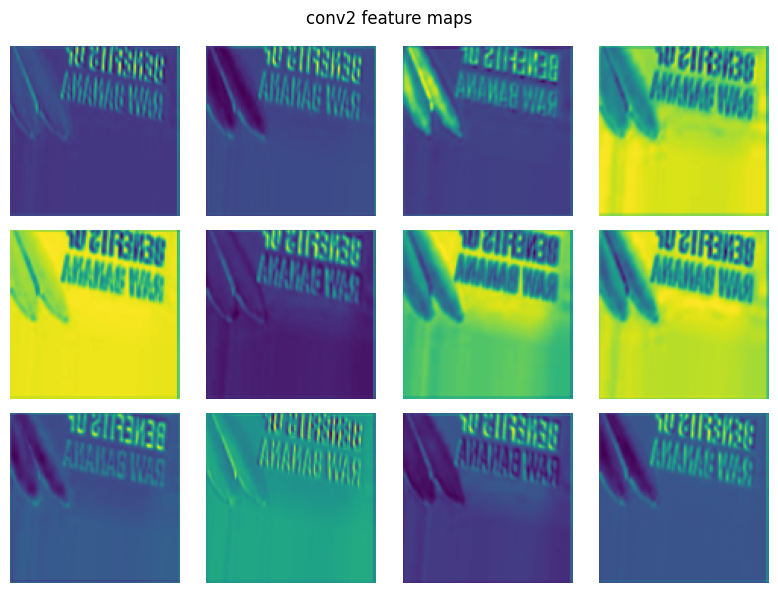

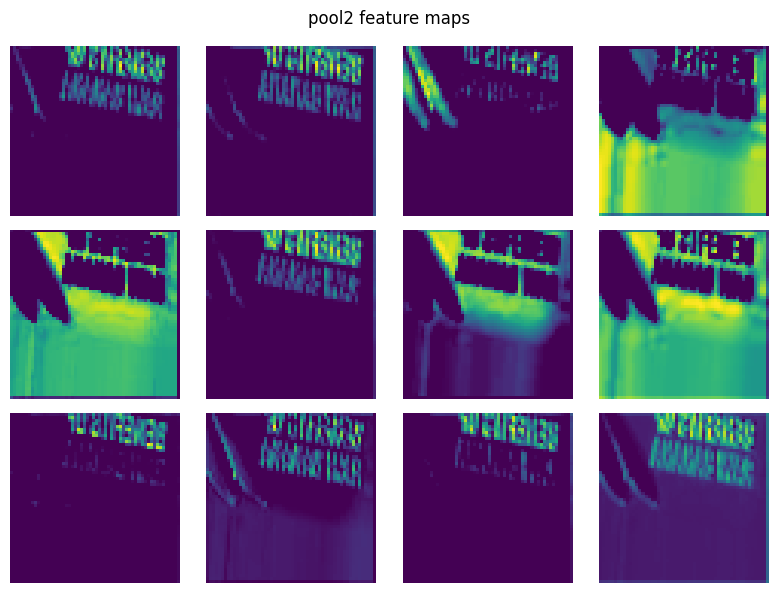

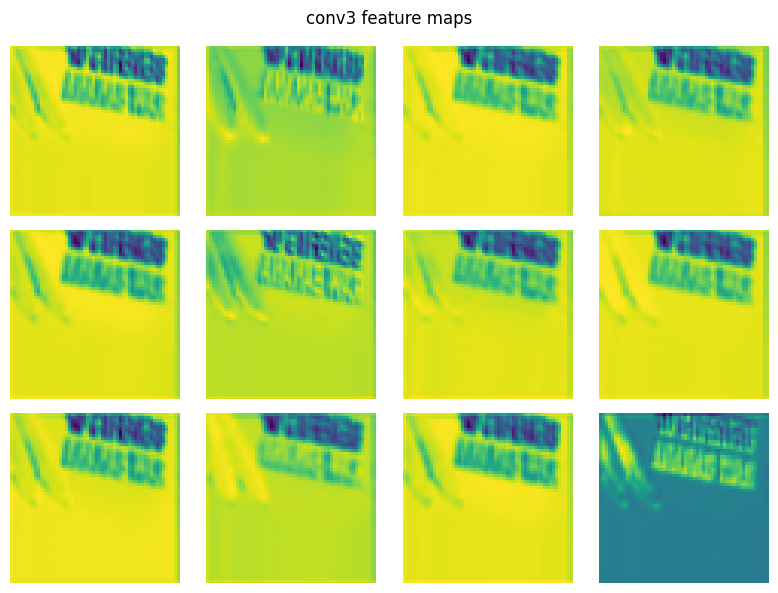

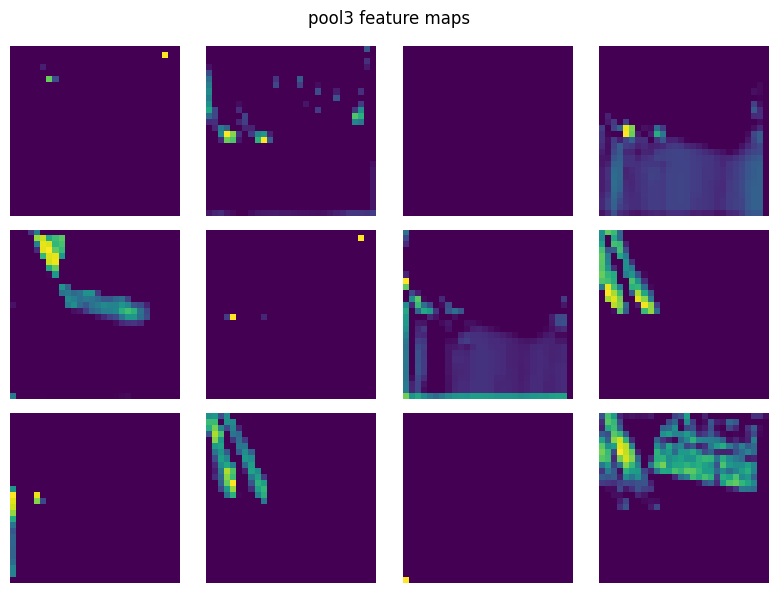

In [27]:
def plot_feature_maps(activation, title, max_channels=16):
    act = activation.squeeze(0)
    channels = min(act.size(0), max_channels)
    cols = 4
    rows = int(np.ceil(channels / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    axes = axes.flatten()
    for idx, ax in enumerate(axes):
        if idx < channels:
            fmap = act[idx]
            fmap = (fmap - fmap.min()) / (fmap.max() - fmap.min() + 1e-5)
            ax.imshow(fmap, cmap='viridis')
        ax.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

layers_to_show = ['conv1', 'pool1', 'conv2', 'pool2', 'conv3', 'pool3']
for layer_name in layers_to_show:
    plot_feature_maps(feature_maps[layer_name], f'{layer_name} feature maps', max_channels=12)


## 8. Activation Statistics
Inspect summary statistics for each activation tensor to spot saturation or dead activations.


In [28]:
for name, activation in feature_maps.items():
    act = activation.cpu()
    print(f'{name:>6} | mean={act.mean():.4f} std={act.std():.4f} min={act.min():.4f} max={act.max():.4f}')


 conv1 | mean=0.1364 std=1.9542 min=-5.4748 max=5.3379
 pool1 | mean=0.3310 std=0.5373 min=0.0000 max=8.8787
 conv2 | mean=0.4546 std=3.6667 min=-28.5405 max=24.4569
 pool2 | mean=0.3568 std=0.7467 min=0.0000 max=8.8409
 conv3 | mean=-5.6968 std=10.5571 min=-87.6294 max=27.5117
 pool3 | mean=0.0295 std=0.1424 min=0.0000 max=2.4442
